# Анализ вакансий
**Часть 5**
## Создание классификатора текстовых блоков объявлений

# 1. Служебный код
## 1.1. Импорт
### 1.1.1. Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sentence_transformers import SentenceTransformer, util
import torch
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from importlib import reload

### 1.1.2. Импорт модулей

In [28]:
import config
reload(config)
from config import settings

import scripts.utils.files as files
reload(files)

import scripts.utils.tasks as tasks

import scripts.model_scripts.text_process as proc
reload(proc)

<module 'scripts.model_scripts.text_process' from '/mnt/data/projects/active/urfu/vkr/scripts/model_scripts/text_process.py'>


## 1.2. Настройка параметров

In [3]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
pd.set_option("plotting.backend", "matplotlib")
warnings.simplefilter("ignore")

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')
RANDOM_STATE = 123

In [4]:
MODEL_SUBDIR = settings.get_fresh('BLOCK_MODELING_SUBDIR')
PROCESSED_SUBDIR = settings.get_fresh('PROCESSED_LOCAL_SUBDIR')
MODEL_LOCAL_DIR = settings.get_fresh('MODEL_LOCAL_DIR')
NLTK_DIR  = settings.get_fresh('NLTK_DIR')
FILENAME_EMB_SUFFIX = settings.get_fresh('FILENAME_EMB_SUFFIX')
DTYPES = settings.get_fresh('types.CSV_DTYPES')

In [5]:
MODEL1_NAME='paraphrase_minilm_l12'
MODEL2_NAME= 'distiluse_cased_v2'
MODEL3_NAME='paraphrase_mpnet_v2'
MODEL4_NAME='stsb_xlm_r'

MODELS = {
    MODEL1_NAME:
              'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
       MODEL2_NAME:
             'sentence-transformers/distiluse-base-multilingual-cased-v2',
         MODEL3_NAME:
              'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
         MODEL4_NAME:
              'sentence-transformers/stsb-xlm-r-multilingual'
}

N_COMPONENTS=[2, 3, 4]

In [6]:
nltk.download('punkt', download_dir=NLTK_DIR)
nltk.download('stopwords', download_dir=NLTK_DIR)

[nltk_data] Downloading package punkt to /var/lib/python/python_venvs/
[nltk_data]     torch_streamlit/lib/nltk_data/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /var/lib/python/python_ve
[nltk_data]     nvs/torch_streamlit/lib/nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

## 1.3. Код (вспомогательные методы)

In [8]:
def classification_metrics(pipeline, X_test, y_test):
    """
    Вывод метрик
    :param pipeline: обученный пайплайн обработки
    :param X_test: тестовая выборка
    :param y_test: значения целевой переменной для тестовой выборки
    :return: None
    """
    y_pred = pipeline.predict(X_test)
    avg = "micro"
    print("f1_score: ", f1_score(y_test, y_pred, average=avg))
    print("accuracy: ", accuracy_score(y_test, y_pred))
    print("precision: ", precision_score(y_test, y_pred, average=avg))
    print("recall: ", recall_score(y_test, y_pred, average=avg))
    confusion_matrix(y_test, y_pred)

# 2. Загрузка данных и общее описание набора данных
## 2.1 Загрузка данных

В качестве исходного набора данных будем использовать размеченный дататасет с извлеченнными разделами:

In [9]:
filename=settings.get_fresh('FILENAME_BLOCKS_EXTRACTED_EDITED')
df_descriptions_ed= files.load_file(filename, PROCESSED_SUBDIR, dtypes = DTYPES,  to_decompress = True, with_dates = False)

In [11]:
df_descriptions_ed

,id,title,content,content_type,semantic_type,block_id
0,42153070,NaN,КОРУС Консалтинг – одна из крупнейших консалти...,0,0,5
1,42153070,"Основной стек технологий, встречающийся на наш...","Классические хранилища: Oracle, PostgreSQL/Gre...",1,0,7
2,42153070,Что нужно делать,взаимодействовать с бизнес-аналитиками команды...,1,2,9
3,42153070,Ждем от вас,опыт взаимодействия с командой разработки;\nоп...,1,3,11
4,42153070,Успешному кандидату готовы предложить,В вопросах компенсации ориентируемся на предло...,1,0,13
...,...,...,...,...,...,...
1365073,13279864,NaN,"Приглашаем присоединиться к команде, которая р...",0,0,1
1365074,13279864,Задачи,Проектирование и разработка высоконагруженных ...,1,2,3
1365075,13279864,Нам важно,Опыт разработки на Java от 2-х;\nОпыт работы с...,1,3,5
1365076,13279864,Дополнительным плюсом будет,Практические навыки работы Spring Core (знания...,1,4,7


## 2.2. Информация о наборе данных

In [12]:
print(f'Строк - {df_descriptions_ed.shape[0]}\nСтолбцов - {df_descriptions_ed.shape[1]}')

Строк - 1365078
Столбцов - 6


In [13]:
df_descriptions_ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365078 entries, 0 to 1365077
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   id             1365078 non-null  int64 
 1   title          995455 non-null   object
 2   content        1364743 non-null  object
 3   content_type   1365078 non-null  int64 
 4   semantic_type  1365078 non-null  int64 
 5   block_id       1365078 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 62.5+ MB


In [12]:
df_descriptions_ed.head()

,id,title,content,content_type,semantic_type,block_id
0,42153070,NaN,КОРУС Консалтинг – одна из крупнейших консалти...,0,0,5
1,42153070,"Основной стек технологий, встречающийся на наш...","Классические хранилища: Oracle, PostgreSQL/Gre...",1,0,7
2,42153070,Что нужно делать,взаимодействовать с бизнес-аналитиками команды...,1,2,9
3,42153070,Ждем от вас,опыт взаимодействия с командой разработки;\nоп...,1,3,11
4,42153070,Успешному кандидату готовы предложить,В вопросах компенсации ориентируемся на предло...,1,0,13


Датасет содержит набор блоков текстов с заголовками, синтаксически извлеченных из оригинальных текстов с описаниями вакансий. Для классификации блоков текста их нужно векторизовать.
 Также есть признак, отражающий семантический тип блока, заполненный вручную, который будет использоваться для формирования меток классов для классификации.

# 3. Подготовка данных
## 3.1. Предобработка датасета
Датасет очень большой, для обучения такой объем избыточен. Уменьшим его.

Проверим его на дубли и на пропуски:

In [10]:
print(f"Дубликатов в данных: {df_descriptions_ed.content.duplicated().sum()}")

Дубликатов в данных: 403365


In [11]:
print(f"Пропусков в данных: {df_descriptions_ed.content.isna().sum()}")

Пропусков в данных: 335


Удаляем дубли и пропуски:

In [12]:
df_descriptions_ed.dropna(inplace=True, ignore_index=True, subset=['content'])
print(f"Пропусков в данных: {df_descriptions_ed.content.isna().sum()}")

Пропусков в данных: 0


In [13]:
df_descriptions_ed.drop(df_descriptions_ed[df_descriptions_ed['content'].duplicated(keep='last')].index, inplace=True, errors="ignore")
df_descriptions_ed.reset_index(drop=True, inplace=True)
print(f"Дубликатов в данных: {df_descriptions_ed.content.duplicated().sum()}")

Дубликатов в данных: 0


## 3.2. Создание меток классов

Посмотрим, как представлены разные значения признака семантического типа в датасете:

In [14]:
semantic_counts = df_descriptions_ed.semantic_type.value_counts()

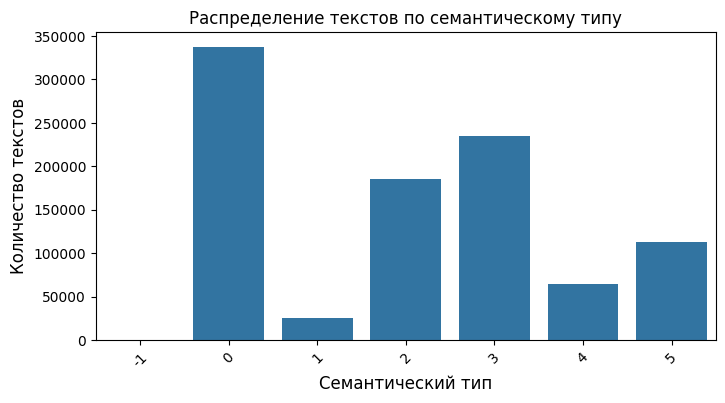

In [15]:
plt.figure(figsize=(8, 4))
sns.barplot(x=semantic_counts.index, y=semantic_counts.values)
plt.title('Распределение текстов по семантическому типу')
plt.ylabel('Количество текстов', fontsize=12)
plt.xlabel('Семантический тип', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Анализ графика показывает, что разные классы представлены не в равной степени, распределение классов у нас
несбалансировано.
Наименее представлен семантический тип 1 - описание. Но к описанию также относятся также блоки типа 0 без заголовка,
которые не были размечены.
Введем 3 новых класса для классификации блоков:
- 0 - описание вакансии (semantictype = 0 или 1);
- 1 - требования (semantictype = 2, 3 или 4);
- 2 - условия работы  (semantictype = 5);

In [16]:
df1=df_descriptions_ed[df_descriptions_ed.semantic_type==1].sample(n=15000)
df1

,id,title,content,content_type,semantic_type,block_id
202140,35168629,Преимущества,Опыт работы на аналогичной позиции более 2 год...,1,1,6
178738,49182307,Наши задачи,Разработка модулей и отчетов 1С:Бухгалтерия 3 ...,1,1,4
8222,50831770,Проект,Mini Royale: Nations -\n это управляемый комью...,2,1,3
446086,37620696,О продукте,Билетная система (полноценная система для авто...,0,1,14
266182,38594235,ТРЕБУЕТСЯ Data Scientist (можно удаленно,"В международную IT- компанию, нашего партнера,...",0,1,3
...,...,...,...,...,...,...
174914,48990135,О компании,Мы занимаемся разработкой решений для электрон...,0,1,2
522963,32826928,Преимущества,Создание аналитического сервиса с высоким уров...,0,1,15
664244,24195290,Что делаем,Разрабатывать корпоративную CRM(с нуля\nРазлич...,0,1,9
506642,29447078,В команду мобильной разработки требуется IOS d...,Motorsport Network\n – крупнейшая в мире мульт...,2,1,2



Составим новую выборку таким образом, чтобы все новые классы были представлены в равном количестве. Примем что
требуемое количество для обучения равно 30000 строк данных каждого нового класса. Выборку будем производить случайным
 образом:

In [17]:
df2=df_descriptions_ed[(df_descriptions_ed.semantic_type==0) & (df_descriptions_ed.title.isna())].sample(n=15000)
df2

,id,title,content,content_type,semantic_type,block_id
111279,44978968,NaN,В отклике я прошу Вас оценить по системе от 1 ...,0,0,8
650029,32204086,NaN,Развивать и поддерживать систему автоматическо...,1,0,7
922311,18221972,NaN,Задание 1. Написать запрос для базы данных Pos...,2,0,8
269540,35954223,NaN,В ходе работу вы:\nИзучите или укрепите знания...,1,0,6
369280,36118945,NaN,В крупную российскую страховую компанию требуе...,0,0,1
...,...,...,...,...,...,...
679530,28890864,NaN,UXCrowd.ru – инновационная краудсорсинговая пл...,0,0,2
557037,33899688,NaN,Наш клиент- Группа компаний «Новые технологии»...,0,0,3
245402,40310282,NaN,В связи с расширением штата ищем сотрудника на...,0,0,1
328310,37734863,NaN,Компания ООО «МАРК» ищет начинающего программи...,0,0,1


In [18]:
df3=(df_descriptions_ed[(df_descriptions_ed.semantic_type.isin([2, 3, 4])) & (df_descriptions_ed.content_type.isin([1, 2]))].sample
     (n=30000))
df3

,id,title,content,content_type,semantic_type,block_id
190956,49914676,Обязанности,Поддержка проектов по вопросам web/app-аналити...,1,2,2
639970,34359654,Обязанности,Поддержка и доработка существующих информацион...,2,2,2
953424,14101006,Требования,"Знание MySQL: индексы, внешние ключи, джойны;\...",1,3,4
342602,39529364,Чем предстоит заниматься,Разработкой/корректировкой электрических принц...,1,2,8
799742,20202699,Обязанности,Проектирование систем автоматизации промышленн...,1,2,2
...,...,...,...,...,...,...
197487,50459415,Требования,Опыт внедрения Битрикс24 и отличное знание про...,1,3,5
642521,33669574,Обязанности,Разработка frontend части наших проектов. Напи...,1,2,3
478851,33292492,Требования,Опыт коммерческой разработки на Kotlin под анд...,1,3,4
673109,23889684,Обязанности,Проектирование и разработка решений по автомат...,1,2,2


In [19]:
df4=df_descriptions_ed[df_descriptions_ed.semantic_type==5].sample(n=30000)
df4

,id,title,content,content_type,semantic_type,block_id
1759,49309105,Условия,Просторный кондиционированный офис в 5 мин. хо...,1,5,11
940693,14344493,Условия работы,Стабильная и надежная компания.\nОфициальное т...,1,5,6
306823,39281124,Что мы предлагаем,Заработная плата обсуждается от 200 -300 по ре...,1,5,11
323636,40491331,Условия,Работа в государственной компании.\nОформление...,1,5,16
224004,40244821,Условия,"Мы готовы обсуждать заработную плату, тк рассм...",1,5,11
...,...,...,...,...,...,...
685675,25187615,Условия,"Официальное трудоустройство, полный социальный...",1,5,11
805070,20705413,Условия,"Полная занятость\nОфис в центре Москвы, от ст....",1,5,9
671440,27818315,Условия,В зависимости от опыта и навыков оплата 90 и б...,1,5,7
274823,36306603,Мы предлагаем,Полностью белую заработную плату от 120 000 ру...,1,5,13


Объединим их в один датасет:

In [20]:
df=pd.concat([df1,df2,df3,df4], ignore_index=True).sample(frac=1).reset_index(drop=True)
df

,id,title,content,content_type,semantic_type,block_id
0,38661200,От кандидата мы ожидаем,"знание HTML5 и CSS3, кросс-браузерная верстка,...",1,3,4
1,24838668,Будет плюсом,понимание и умение писать простейшие MySQL-зап...,1,4,7
2,25877176,Наши условия,Возможность удаленной работы или работы в Моск...,1,5,4
3,40397206,NaN,"Система электронных платежей нового поколения,...",1,0,4
4,24466896,Функционал,"сбор, анализ, формализация, документирование и...",1,1,4
...,...,...,...,...,...,...
89995,26587460,NaN,Уважаемые соискатели! Огромная просьба внимате...,0,0,1
89996,43484107,Плюсом будет,Опыт работы в технической поддержке ДБО и CRM\...,1,4,6
89997,34928992,Задачи,Разработка Web приложений на платформе Microso...,1,2,3
89998,12053271,"Мы ищем специалиста, который",Обладает хорошим знанием возможностей платформ...,1,3,9


Создадим новый столбец target_type и удалим старый столбец semantic_type

In [21]:
mapper={0:0, 1:0, 2:1,3:1,4:1,5:2}
df['target_type'] = pd.to_numeric(df['semantic_type'].map(mapper), downcast='unsigned')
df.drop(columns=['semantic_type', 'content_type', 'id', 'block_id'], inplace=True, errors='ignore')
df

,title,content,target_type
0,От кандидата мы ожидаем,"знание HTML5 и CSS3, кросс-браузерная верстка,...",1
1,Будет плюсом,понимание и умение писать простейшие MySQL-зап...,1
2,Наши условия,Возможность удаленной работы или работы в Моск...,2
3,NaN,"Система электронных платежей нового поколения,...",0
4,Функционал,"сбор, анализ, формализация, документирование и...",0
...,...,...,...
89995,NaN,Уважаемые соискатели! Огромная просьба внимате...,0
89996,Плюсом будет,Опыт работы в технической поддержке ДБО и CRM\...,1
89997,Задачи,Разработка Web приложений на платформе Microso...,1
89998,"Мы ищем специалиста, который",Обладает хорошим знанием возможностей платформ...,1


## 3.3. Предобработка блоков текста

Для векторизации блоков текста получим их эмбединги с использованием библиотеки Sentence-transformers, предоставляющей простые методы вычисления эмбедингов (плотных векторных представлений) для предложений, абзацев и изображений. Эта библиотека включает как  готовые предварительно обученные модели для векторизации текста, так и соответствующие им средства токенизации. Есть многоязыковый модели с поддержкой русского языка, однако токенизайия производится без учета флективности русского языка. Поэтому блоки текста перед тем, как они будут переданы бибилиотеке для обработки, должны быть предварительно обработаны. Для этого необходимо:
 - разбить блоки на токены;
- выполнить лемматизацию токенов;
- исключить стоп-слова;
- оставшиеся термы снова собрать в блок текста, с учетом разделителей предложений (точек).
Векторизация блоков текстов выполнялась с помощью скрипта proc.tokenize_blocks:

In [141]:
new_df = tasks.apply_parallel(df, proc.tokenize_blocks)

In [30]:
new_df['raw_block']=new_df.title
new_df.raw_block.fillna("",inplace=True)
new_df['raw_block']=new_df.raw_block.str.lower()+'. ' + new_df.content.str.lower()

In [32]:
df=new_df.copy()
df.drop(columns=['title', 'content'], inplace=True, errors='ignore')

Для выполнения классификации будет использоваться новый признак - 'tokenized_block'.
Проверим его на дубли и на пропуски:

In [148]:
print(f"Дубликатов в данных: {df.tokenized_block.duplicated().sum()}")

Дубликатов в данных: 533


In [149]:
print(f"Пропусков в данных: {df.tokenized_block.isna().sum()}")

Пропусков в данных: 0


Удаляем дубли и пропуски:

In [133]:
df.dropna(inplace=True, ignore_index=True, subset=['tokenized_block'])
print(f"Пропусков в данных: {df.tokenized_block.isna().sum()}")

Пропусков в данных: 0


In [153]:
df.drop(df[df['tokenized_block'].duplicated(keep='last')].index, inplace=True, errors="ignore")
df.reset_index(drop=True, inplace=True)
print(f"Дубликатов в данных: {df.tokenized_block.duplicated().sum()}")

Дубликатов в данных: 0


In [24]:
df

,target_type,tokenized_block,raw_block
0,1,чем предстоять заниматься.участвовать в обсужд...,чем предстоит заниматься. участвовать в обсужд...
1,2,условие.полный рабочий день.как работа в офис ...,условия. полный рабочий день;\nкак работа в оф...
2,1,требование.знакомство с мобильный разработка п...,требования. знакомство с мобильной разработкой...
3,2,условие.комфортный офис в пешеходный доступнос...,условия. комфортный офис в пешеходной доступно...
4,0,о мы.g soft это развивающийся софтверный компа...,о нас. g-soft – это развивающаяся софтверная к...
...,...,...,...
89462,0,csssr крупный цех по производство фронтенд в р...,. csssr — крупнейший цех по производству фронт...
89463,2,мы предлагать.высокий заработный плата 210 000...,мы предлагаем. высокая заработная плата 210 00...
89464,1,задача.разработка серверный часть платёжный си...,задачи. разработка серверной части платежной с...
89465,0,мы расти и развиваться поэтому мы в команда тр...,". мы растем и развиваемся, поэтому нам в коман..."


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89467 entries, 0 to 89466
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   target_type      89467 non-null  uint8 
 1   tokenized_block  89467 non-null  object
 2   raw_block        89467 non-null  object
dtypes: object(2), uint8(1)
memory usage: 1.5+ MB


Уникальных значений:

In [23]:
df.nunique()

target_type            3
tokenized_block    89466
raw_block          89467
dtype: int64

Все тексты в наборе данных уникальны.

## 3.4. Сохранение датасета

Сохраним полученный датасет:

In [155]:
filename=settings.get_fresh('FILENAME_BLOCKS_TOKENIZED')
files.save_dataframe(df,filename, MODEL_SUBDIR, to_compress=True)

'/home/svs/data/projects/active/urfu/vkr/data/processed/blocks_tokenized_004.csv.gz'

Загрузка этого датасета:

In [22]:
filename=settings.get_fresh('FILENAME_BLOCKS_TOKENIZED')
df= files.load_file(filename, MODEL_SUBDIR, to_decompress=True, with_dates=False)

# 4. Исследовательский анализ данных (exploratory data analysis - EDA)

Ранее уже были выполнены очистка, разделение текста на токены, морфологическая обработка токенов. Для этого, как и раньше,

Длина текстов в символах

Максимальная длина текста:  6731
Минимальная длина текста:  0
Средняя длина текста:  327


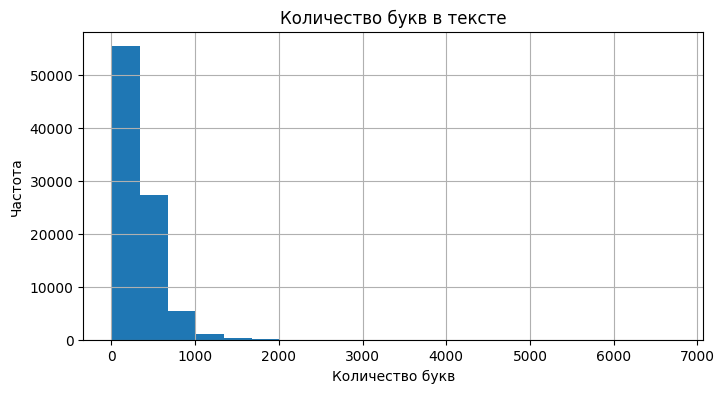

In [157]:
# Количество букв в каждом тексте
df["letter_count"]=df['tokenized_block'].apply(len)
print("Максимальная длина текста: ",df.letter_count.max())
print("Минимальная длина текста: ",df.letter_count.min())
print("Средняя длина текста: ",round(df.letter_count.mean()))
df.groupby('target_type')['letter_count'].describe()
plt.figure(figsize=(8, 4))
bins = 20
plt.hist(df['letter_count'], bins=bins)
plt.xlabel('Количество букв')
plt.ylabel('Частота')
plt.title('Количество букв в тексте')
plt.grid()
plt.show()

Длина текстов в словах

Максимальная длина текста:  936
Минимальная длина текста:  0
Средняя длина текста:  40
Медиана длины текста:  33


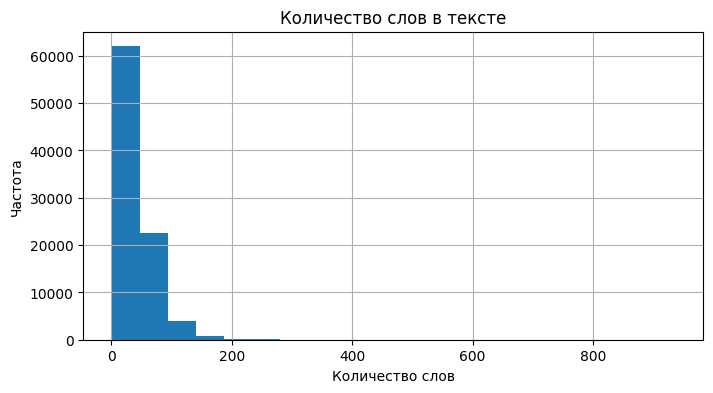

In [158]:
# Количество слов в каждом тексте
df['word_count']=df['tokenized_block'].astype(str).str.split().map(lambda x: len(x))
print("Максимальная длина текста: ",df.word_count.max())
print("Минимальная длина текста: ",df.word_count.min())
print("Средняя длина текста: ",round(df.word_count.mean()))
print("Медиана длины текста: ",round(df.word_count.median()))
df.groupby('target_type')['word_count'].describe()
plt.figure(figsize=(8, 4))
bins = 20
plt.hist(df['word_count'], bins=bins)
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.title('Количество слов в тексте')
plt.grid()
plt.show()

Общая статистика

In [159]:
df.describe()

,target_type,letter_count,word_count
count,89467.000000,89467.000000,89467.000000
mean,1.000749,327.245711,39.938212
std,0.815489,234.071370,30.059543
min,0.000000,0.000000,0.000000
25%,0.000000,167.000000,19.000000
50%,1.000000,274.000000,33.000000
75%,2.000000,426.000000,52.000000
max,2.000000,6731.000000,936.000000


В текстах от 1 до 936 слов, в среднем 33, верхнему квартилю соответствует значение 52.
Аналогично, в текстах от 0 до 6731 символов, в среднем 274, верхнему квартилю соответствует значение 426.

In [160]:
print("Всего символов: ", df.letter_count.sum())
print("Всего слов: ", df.word_count.sum())

Всего символов:  29277692
Всего слов:  3573152


Найдем слова, встречающиеся чаще всего в текстах

In [161]:
popular_words=[]
for text in df.tokenized_block.values:
    popular_words +=text.split()
popular_words = pd.Series(popular_words).value_counts(sort=True,ascending=False )
popular_words.index.rename('word', True)
print("Всего уникальных слов: ", popular_words.nunique())
popular_words.head(10)

Всего уникальных слов:  1211


word
и             173793
в             130356
с              82641
работа         55571
на             54176
по             42659
для            31682
мы             31313
разработка     26370
от             23961
Name: count, dtype: int64

Из слов самые популярные оказались артикли, союзы, модальные глаголы и предлоги.
В целом тексты по своему составу достаточно стандартны, что позволяет использовать существующие обученные для
русского языка модели и библиотеки.

# 5. Классификация блоков текста

## 5.1. Векторизация текста

Тексты блоков достаточно длинные, поэтому для их векторизации использовались плотные векторные представления
(эмбединги), полученные с помощью библиотеки Sentence-transformers.


In [29]:
emb_dict={}
FILENAME_BLOCK_VECTORIZATION_MODEL = settings.get_fresh('FILENAME_BLOCK_VECTORIZATION_MODEL')
for m_key in MODELS:
   model = SentenceTransformer(MODELS[m_key])
   print('encoding '+m_key + str(datetime.now()))
   embeddings = model.encode(df.tokenized_block, device=DEVICE)
   emb_dict[f'{m_key}_emb']=embeddings
   # filename = f'{m_key}_{FILENAME_EMB_SUFFIX}'
   # processed_data_file_path = files.save_data_dump(embeddings, filename, MODEL_SUBDIR)
   filename = f'{m_key}_{FILENAME_BLOCK_VECTORIZATION_MODEL}'
   processed_data_file_path = files.save_model(model, filename)
   print('Сохранено: '+ processed_data_file_path)
   print('done '+m_key+str(datetime.now()))
print(datetime.now())

encoding paraphrase_minilm_l122024-05-21 15:34:59.943421
Сохранено: /mnt/docs/DataStorage/vkr/models/paraphrase_minilm_l12_block_vectorization_model.dmp
done paraphrase_minilm_l122024-05-21 15:36:32.818011
encoding distiluse_cased_v22024-05-21 15:36:35.808025
Сохранено: /mnt/docs/DataStorage/vkr/models/distiluse_cased_v2_block_vectorization_model.dmp
done distiluse_cased_v22024-05-21 15:38:52.397851
encoding paraphrase_mpnet_v22024-05-21 15:38:56.524799
Сохранено: /mnt/docs/DataStorage/vkr/models/paraphrase_mpnet_v2_block_vectorization_model.dmp
done paraphrase_mpnet_v22024-05-21 15:43:00.234774
encoding stsb_xlm_r2024-05-21 15:43:04.389239
Сохранено: /mnt/docs/DataStorage/vkr/models/stsb_xlm_r_block_vectorization_model.dmp
done stsb_xlm_r2024-05-21 15:47:08.126073
2024-05-21 15:47:08.126332


Визуализация векторного представления

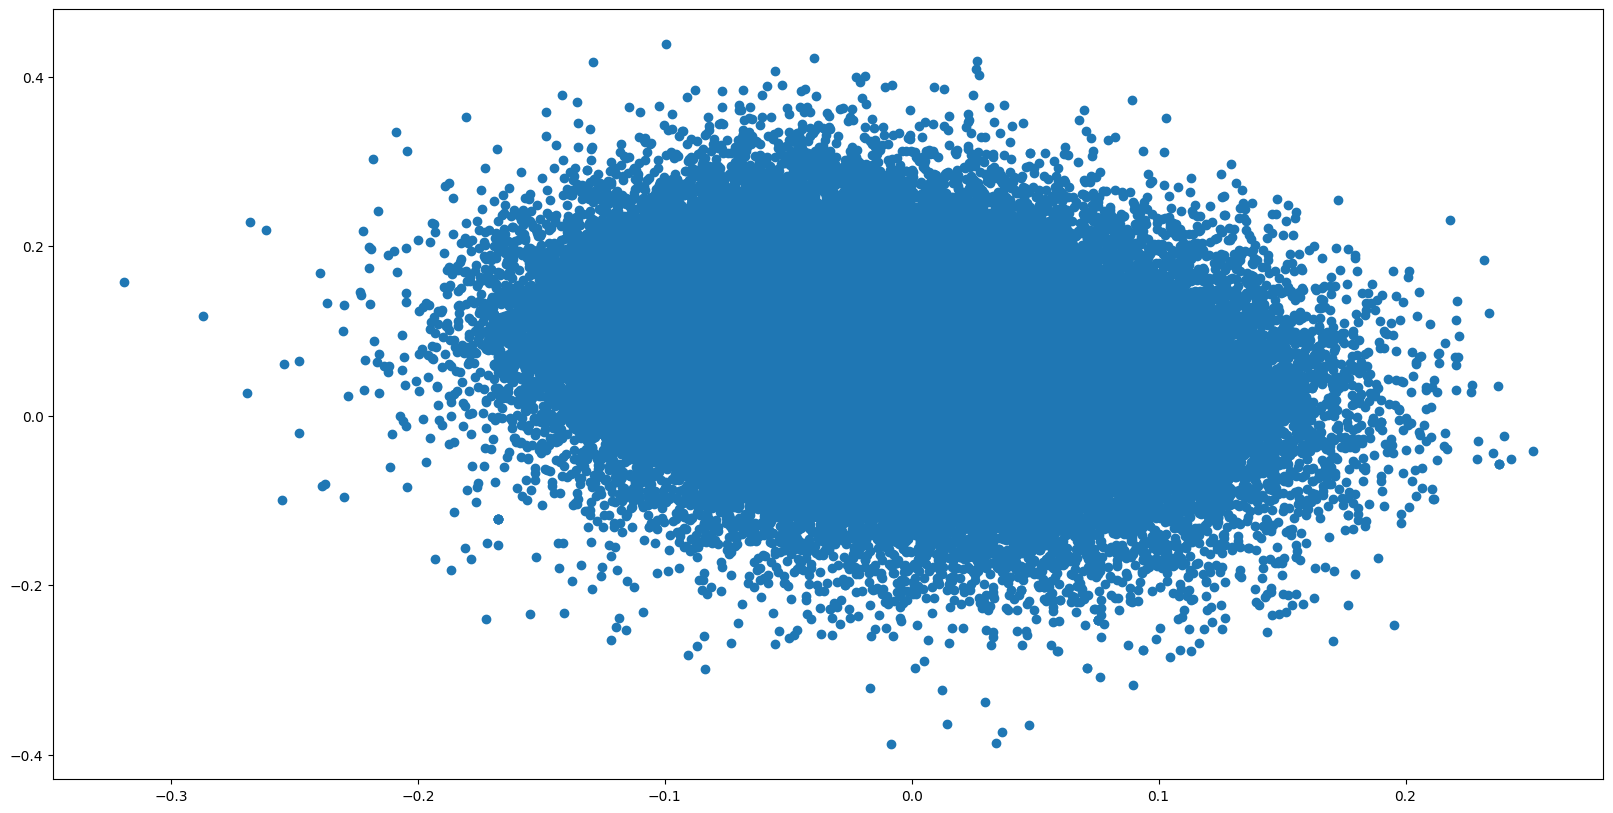

In [30]:
plt.figure(figsize=(20,10))
plt.scatter(emb_dict[f'{MODEL3_NAME}_emb'][:,0], emb_dict[f'{MODEL3_NAME}_emb'][:,1])

In [31]:
filename=settings.get_fresh('FILENAME_BLOCK_EMBEDDINGS')
processed_data_file_path = files.save_data_dump(emb_dict, filename, MODEL_SUBDIR)
processed_data_file_path

'/mnt/docs/DataStorage/vkr/data/block_modeling/block_embeddings_002.dmp'

In [43]:
filename=settings.get_fresh('FILENAME_BLOCK_EMBEDDINGS')
emb_dict = files.load_data_dump(filename, MODEL_SUBDIR)

Выделяем данные для обучения и тестирования

## 5.2. Выбор метрики оценки качества для алгоритмов
Будем использовать метрики accuracy и F1-оценку.
Accuracy — это основной показатель, который описывает общую точность предсказания модели по всем классам. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству.
F1-оценка: Эта более сложная метрика учитывает баланс между точностью (precision) и полнотой (recall).

## 5.3. Классификация методом логистической регрессии

In [32]:
y= df['target_type']
for m_key in MODELS:
    print(MODELS[m_key])
    X=emb_dict[f'{m_key}_emb']
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=RANDOM_STATE)
    lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=100)
    lr.fit(X_train, y_train)    
    print(lr.score(X_test, y_test))
    y_pred = lr.predict(X_test)
    f1_score_ml = f1_score(y_test, y_pred, average='weighted')
    print('f1_score=', f1_score_ml)
    print('accuracy=', accuracy_score(y_test, y_pred))
    classification_metrics = classification_report(y_test, y_pred, target_names=[ '0','1', '2'])
    print(classification_metrics)
    print('________________________')

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
0.8952721582653403
f1_score= 0.8944778668804744
accuracy= 0.8952721582653403
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      8915
           1       0.90      0.93      0.92      9073
           2       0.91      0.94      0.92      8853

    accuracy                           0.90     26841
   macro avg       0.89      0.90      0.89     26841
weighted avg       0.89      0.90      0.89     26841

________________________
sentence-transformers/distiluse-base-multilingual-cased-v2
0.8960917998584256
f1_score= 0.8948040950936924
accuracy= 0.8960917998584256
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      8915
           1       0.90      0.95      0.92      9073
           2       0.90      0.94      0.92      8853

    accuracy                           0.90     26841
   macro avg       0.90      0.90      0.89     2

Выбранная модель векторизации:

In [43]:
selected_model=MODEL3_NAME

Подбор гиперпараметров логистической регрессии:

In [ ]:
X=emb_dict[f'{selected_model}_emb']
y= df['target_type']
param_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [.5, 1, 2],
    'solver' : ['lbfgs','newton-cg','liblinear','saga'],
    'max_iter' : [100, 300, 500, 1000]
    }
]

lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=100)
lr_hypertuned = GridSearchCV(lr, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
res_hypertuned = lr_hypertuned.fit(X,y)
best_estimator = res_hypertuned.best_estimator_

Найденные оптимальные параметры:

In [222]:
print(best_estimator)

LogisticRegression(C=0.5, max_iter=300, penalty='none', random_state=123,
                   solver='saga')


Определяем долю правильных ответов (accuracy) и метрику f1_score на тестовом наборе данных

In [226]:
#Найденные гиперпараметры:
# LogisticRegression(C=0.5, max_iter=300, penalty='none', random_state=123,solver='saga')
X=emb_dict[f'{selected_model}_emb']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=RANDOM_STATE)
y_pred = best_estimator.predict(X_test)
classification_metrics = classification_report(y_test, y_pred, target_names=[ '0','1', '2'])
print(classification_metrics)
f1_score_ml = f1_score(y_test, y_pred, average='weighted')
print('f1_score=', f1_score_ml)
print('accuracy=', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      8915
           1       0.93      0.96      0.95      9073
           2       0.94      0.96      0.95      8853

    accuracy                           0.93     26841
   macro avg       0.93      0.93      0.93     26841
weighted avg       0.93      0.93      0.93     26841

f1_score= 0.9299181510773732
accuracy= 0.9303304645877576


In [45]:
filename=settings.get_fresh('FILENAME_BLOCK_CLASSIFICATION_MODEL')
processed_data_file_path = files.save_model(best_estimator, filename)
print(processed_data_file_path)

/mnt/docs/DataStorage/vkr/models/block_classification_model_002.dmp
